# Full-waveform inversion using Forge

In this notebook we apply full-waveform inversion (FWI) to a small, relatively simple demo model. FWI is a high-resolution data-intensive tomographic imaging method, originally developed in geophysics for imaging the subsurface. 

By default, Forge will automatically attempt to run the forward modelling and inversion on the GPU. If a suitably configured cuda-enabled GPU is not available, it will revert to the CPU. The problem presented here is intentially small enough so that this is not an issue. 

### Contents

1. Model definition
2. Acquisition setup
3. Forward modelling
4. Optimization

## 1. Model definition

In [1]:
# choose the frequency of the source wavelet and the acoustic velocities of the model
frequency = 2e5
min_vel = 1480
med_vel = 1520
max_vel = 1620

Set the spatial increment, `dx`, to be small enough to sufficiently mitigate numerical dispersion by ensuring there are a 6 grid-points per wavelength.

In [2]:
min_wavelength = min_vel/frequency
dx = min_wavelength/6
print(f'spatial increment dx: {dx:.3g}')

spatial increment dx: 0.00123


Set the temporal increment, `dt`, to be small enough to meet the CFL condition for numerical stability. 

In [3]:
courant_num = 0.61 
dt = (courant_num*dx)/max_vel
print(f'temporal increment dt: {dt:.3g}')

temporal increment dt: 4.64e-07


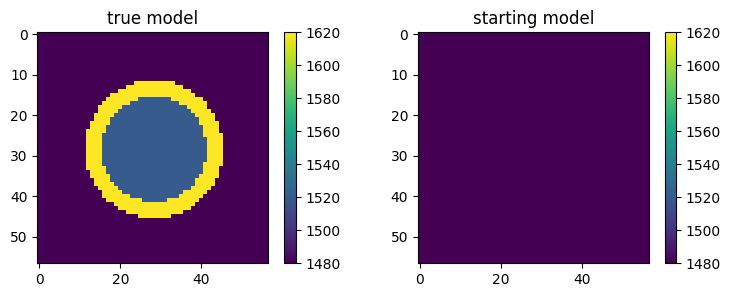

In [4]:
from forge.utils import demo_model

# define the true model, m, and the inversion starting model m0
m, m0 = demo_model(dx, min_vel, med_vel, max_vel, plot=True)

## 2. Acquisition setup

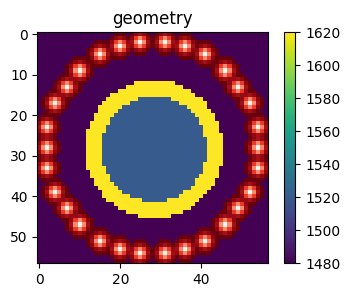

In [5]:
from forge.utils import demo_geometry

# define the receiver and source geometry
r_pos = demo_geometry(m, n_elements=30, plot=True)
s_pos = r_pos.copy()

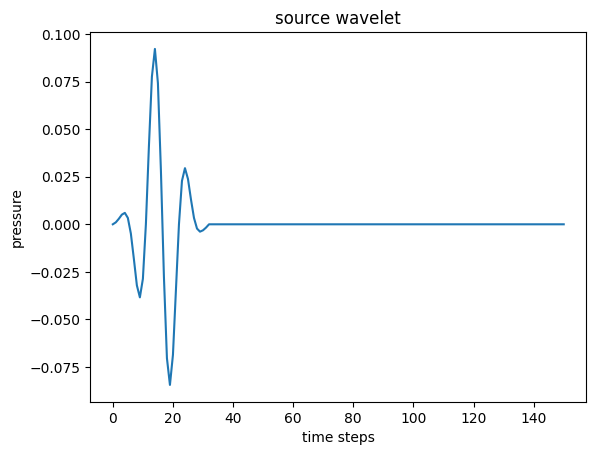

In [6]:
from forge.utils import tone_burst

time = 0.00007 # maximum time in seconds
amplitude = 1e-1 # source amplitude
num_tsteps = round(time/dt) # number of time-steps
num_cycles = 3 # use a 3 cycle tone-burst

# define the source wavelet 
source = tone_burst(dt, frequency, num_cycles, num_tsteps, amplitude, plot=True)

## 3. Forward modelling

In [7]:
from forge.model import FullWaveformInversion

# instantiate a Forge WaveformInversion_2d class
true_model = FullWaveformInversion(model = m, # true model
                                   dx = dx, # spatial increment
                                   dt = dt, # temporal increment
                                   r_pos = r_pos) # receiver positions

device = cuda:0


In [8]:
# forward modelling using the source wavelet at the source positions
true_model.forward(s_pos, source)

forward modelling: 100%|█████████████████████| 151/151 [00:00<00:00, 231.39it/s]


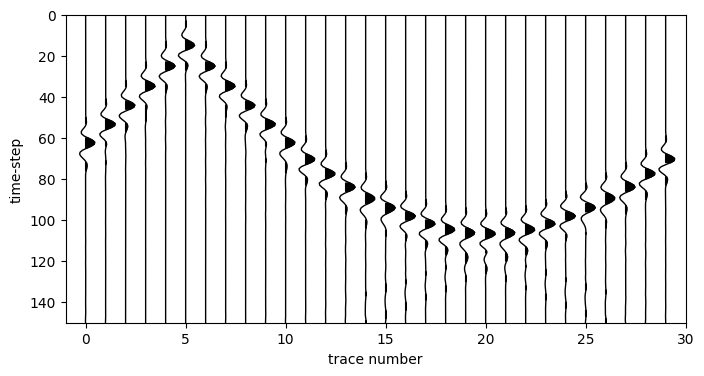

In [9]:
from forge.utils import trace_plot, trace_normalize

# visualize traces of true modelled data
trace_plot(trace_normalize(true_model.d), 5)

In [10]:
from forge.utils import animate, HTML

# animate partial derivative of forward wavefield with respect to the model
ani = animate(true_model.wavefield.cpu())
HTML(ani.to_jshtml())

## 4. Inversion

In [11]:
# instantiate a new Forge WaveformInversion_2d class for the inversion
model = FullWaveformInversion(model = m0, # starting model
                              dx = dx, # spatial increment
                              dt = dt, # temporal increment
                              r_pos = r_pos) # receiver positions

device = cuda:0


### Optimizers

PyTorch contains a suite of optimizers that can be selected and tuned accordingly.

In [12]:
import torch

# define a stochastic gradient descent optimizer with momentum
opt = torch.optim.SGD([model.m], lr=1e-5, momentum=0.4)

In [13]:
l2_loss = torch.nn.MSELoss()

### Loss function

Loss functions need to be defined explicitly in Forge.

In [14]:
# define a standard trace-normalized L2 loss function 
def l2_loss2(input, target):
    return torch.norm(trace_normalize(input) - trace_normalize(target))**2

In [15]:
type(l2_loss)

torch.nn.modules.loss.MSELoss

In [16]:
isinstance(l2_loss, torch.nn.modules.loss.Callable)

True

In [17]:
type(l2_loss2)

function

### Callbacks

A default optimization loop can be executed with `.fit()`. For ease and flexible customization, an arbitrary number of callback functions can be defined to act on 1. the adjoint source prior to back-propagation and/or 2. the model gradient and/or parameters prior to taking an optimization step.

For example, these could be regularization terms, filters, or plotting functions to visualize adjoint sources or gradients.

In [18]:
from scipy.ndimage import gaussian_filter
from forge.utils import butter_filter

# define a Gaussian smoothing callback function for the model gradient
def grad_smoothing(m, sigma=0.1):
    m.grad[model.bp:-model.bp, model.bp:-model.bp] = torch.from_numpy(
                gaussian_filter(m.grad.cpu()[model.bp:-model.bp, model.bp:-model.bp], sigma))

# define a function to low pass filter the adjoint source
def low_pass(adjoint_source):
    adjoint_source = torch.from_numpy(butter_filter(adjoint_source, 4e5, 1/dt, order=12)).float()

In [19]:
# invert the data with .fit()
model.fit(data = true_model.d, # truedata
          s_pos = s_pos, # source locations as indices
          source = source, # source wavelet
          optimizer = opt, # optimizer
          loss = l2_loss, # loss function
          num_iter = 10, # number of iterations per frequency block
          bs = 10, # batch size/number of sources per forward run
          blocks = [1e5, 2e5], # multi-scale frequency blocks
          model_callbacks = [grad_smoothing], # apply model/gradient callbacks before the optimization step
          adjoint_callbacks = [low_pass], # apply adjoint source callbacks before back-propagation
          box = (min_vel, max_vel), # box constraints
          true_model = m) # true model for reporting inversion RMSE

2024-04-18 16:05:59  block 1/2    1e+05Hz
2024-04-18 16:05:59    iteration 1/10


adjoint modelling: 100%|█████████████████████| 151/151 [00:00<00:00, 399.29it/s]


2024-04-18 16:05:59      loss = 4.311e-15
2024-04-18 16:05:59      rmse = 0.01336
2024-04-18 16:05:59    iteration 2/10


adjoint modelling: 100%|█████████████████████| 151/151 [00:00<00:00, 396.60it/s]


2024-04-18 16:06:00      loss = 2.172e-15
2024-04-18 16:06:00      rmse = 0.01087
2024-04-18 16:06:00    iteration 3/10


adjoint modelling: 100%|█████████████████████| 151/151 [00:00<00:00, 373.36it/s]


2024-04-18 16:06:01      loss = 8.257e-16
2024-04-18 16:06:01      rmse = 0.008969
2024-04-18 16:06:01    iteration 4/10


adjoint modelling: 100%|█████████████████████| 151/151 [00:00<00:00, 397.05it/s]


2024-04-18 16:06:02      loss = 3.827e-16
2024-04-18 16:06:02      rmse = 0.007827
2024-04-18 16:06:02    iteration 5/10


adjoint modelling: 100%|█████████████████████| 151/151 [00:00<00:00, 394.71it/s]


2024-04-18 16:06:03      loss = 1.523e-16
2024-04-18 16:06:03      rmse = 0.006649
2024-04-18 16:06:03    iteration 6/10


adjoint modelling: 100%|█████████████████████| 151/151 [00:00<00:00, 365.80it/s]


2024-04-18 16:06:04      loss = 8.477e-17
2024-04-18 16:06:04      rmse = 0.005668
2024-04-18 16:06:04    iteration 7/10


adjoint modelling: 100%|█████████████████████| 151/151 [00:00<00:00, 386.42it/s]


2024-04-18 16:06:04      loss = 5.933e-17
2024-04-18 16:06:04      rmse = 0.00523
2024-04-18 16:06:04    iteration 8/10


adjoint modelling: 100%|█████████████████████| 151/151 [00:00<00:00, 384.35it/s]


2024-04-18 16:06:05      loss = 2.998e-17
2024-04-18 16:06:05      rmse = 0.004859
2024-04-18 16:06:05    iteration 9/10


adjoint modelling: 100%|█████████████████████| 151/151 [00:00<00:00, 365.43it/s]


2024-04-18 16:06:06      loss = 6.955e-17
2024-04-18 16:06:06      rmse = 0.004741
2024-04-18 16:06:06    iteration 10/10


adjoint modelling: 100%|█████████████████████| 151/151 [00:00<00:00, 383.06it/s]


2024-04-18 16:06:07      loss = 2.679e-17
2024-04-18 16:06:07      rmse = 0.004454
______________________________________________________________________ 

2024-04-18 16:06:07  block 2/2    2e+05Hz
2024-04-18 16:06:07    iteration 1/10


adjoint modelling: 100%|█████████████████████| 151/151 [00:00<00:00, 393.92it/s]


2024-04-18 16:06:08      loss = 3.726e-15
2024-04-18 16:06:08      rmse = 0.004291
2024-04-18 16:06:08    iteration 2/10


adjoint modelling: 100%|█████████████████████| 151/151 [00:00<00:00, 378.45it/s]


2024-04-18 16:06:08      loss = 2.951e-15
2024-04-18 16:06:08      rmse = 0.004103
2024-04-18 16:06:08    iteration 3/10


adjoint modelling: 100%|█████████████████████| 151/151 [00:00<00:00, 379.38it/s]


2024-04-18 16:06:09      loss = 9.43e-15
2024-04-18 16:06:09      rmse = 0.00386
2024-04-18 16:06:09    iteration 4/10


adjoint modelling: 100%|█████████████████████| 151/151 [00:00<00:00, 393.20it/s]


2024-04-18 16:06:10      loss = 1.814e-15
2024-04-18 16:06:10      rmse = 0.003722
2024-04-18 16:06:10    iteration 5/10


adjoint modelling: 100%|█████████████████████| 151/151 [00:00<00:00, 392.71it/s]


2024-04-18 16:06:11      loss = 6.782e-15
2024-04-18 16:06:11      rmse = 0.003471
2024-04-18 16:06:11    iteration 6/10


adjoint modelling: 100%|█████████████████████| 151/151 [00:00<00:00, 399.29it/s]


2024-04-18 16:06:12      loss = 5.59e-16
2024-04-18 16:06:12      rmse = 0.003337
2024-04-18 16:06:12    iteration 7/10


adjoint modelling: 100%|█████████████████████| 151/151 [00:00<00:00, 381.10it/s]


2024-04-18 16:06:13      loss = 9.66e-16
2024-04-18 16:06:13      rmse = 0.003251
2024-04-18 16:06:13    iteration 8/10


adjoint modelling: 100%|█████████████████████| 151/151 [00:00<00:00, 357.24it/s]


2024-04-18 16:06:13      loss = 3.945e-15
2024-04-18 16:06:13      rmse = 0.003194
2024-04-18 16:06:13    iteration 9/10


adjoint modelling: 100%|█████████████████████| 151/151 [00:00<00:00, 382.09it/s]


2024-04-18 16:06:14      loss = 1.515e-15
2024-04-18 16:06:14      rmse = 0.003395
2024-04-18 16:06:14    iteration 10/10


adjoint modelling: 100%|█████████████████████| 151/151 [00:00<00:00, 384.24it/s]

2024-04-18 16:06:15      loss = 1.139e-14
2024-04-18 16:06:15      rmse = 0.002995
______________________________________________________________________ 



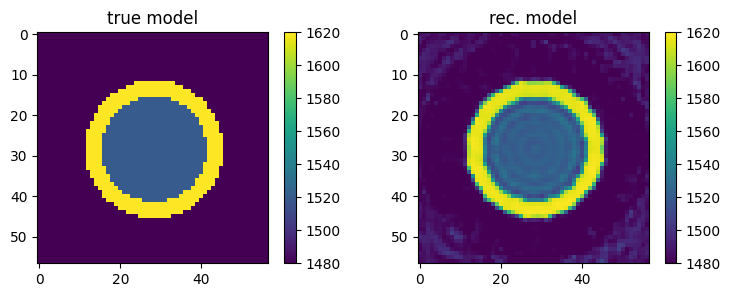

In [20]:
import matplotlib.pyplot as plt

# compare the true vs the FWI recovered model
plt.figure(figsize=(9,3))
plt.subplot(1,2,1)
plt.imshow(m, vmin=min_vel, vmax=max_vel)
plt.title('true model')
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(model.get_model(), vmin=min_vel, vmax=max_vel)
plt.title('rec. model')
plt.colorbar()
plt.show()

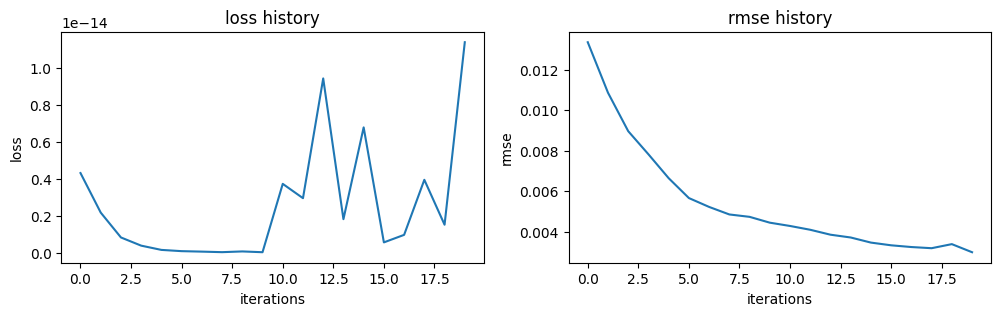

In [21]:
# view the inversion statistics
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
plt.plot(model.loss_history)
plt.title('loss history')
plt.xlabel('iterations')
plt.ylabel('loss')

plt.subplot(1,2,2)
plt.plot(model.rmse_history)
plt.title('rmse history')
plt.xlabel('iterations')
plt.ylabel('rmse')
plt.show()